## 3.0 Intro
This notebook is about employing Doc2vec algorithm to create rappers vectors and then try to see if clustering and visualizing "rappers space" conforms our intuitions about them.

In [1]:
from gensim import models, corpora, similarities
from gensim.models import Doc2Vec
from tqdm import tqdm
import json
import os
import re

/home/jack/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


You only need to set the **MAIN_PATH** variable

In [2]:
MAIN_PATH = "/home/jack/datasets/polish_rap/"

In [3]:
RAPPERS_PATH = MAIN_PATH + "stm_lyrics/"
DOC2VEC_FILES_PATH = MAIN_PATH + "/d2v_files/"
DOC2VEC_CONFIG_PATH = MAIN_PATH + "d2v_config/"

In [4]:
# preprocess files for Doc2Vec
# documents are dynamically constructed from rappers' lyrics

def preprocess_documents(rappers_list):
    if not os.path.exists(DOC2VEC_FILES_PATH): 
        os.mkdir(DOC2VEC_FILES_PATH)
    
    for rapper in tqdm(rappers_list):
        rapper_allsongs = ""
        songs = os.listdir(RAPPERS_PATH + rapper)
        for song in songs:
            with open(RAPPERS_PATH + rapper + "/" + song, "r") as f:
                song_text = json.load(f)
            rapper_allsongs += song_text["lyrics"]
        re.sub("\s\n\s\n", "\n", rapper_allsongs) # it doesn't work, i have no idea why!!!
        with open(DOC2VEC_FILES_PATH + rapper, "w") as f:
            f.write(rapper_allsongs)

In [5]:
def get_populars():
    with open(DOC2VEC_CONFIG_PATH + "popular_rappers.json", "r") as f:
        popular_rappers_frame = json.load(f)
    return popular_rappers_frame["allwords"].keys()

In [6]:
import itertools

def head(d):
    return dict(itertools.islice(d.items(), 10))

In [7]:
popular_rappers = get_populars()

In [8]:
popular_rappers = set(popular_rappers)
popular_rappers -= set("Wbw")
popular_rappers -= set("Mickiewicz")

In [9]:
preprocess_documents(popular_rappers)

100%|██████████| 53/53 [00:00<00:00, 113.54it/s]


### 3.1 Doc2Vec corpus creation
from http://radimrehurek.com/gensim/tut1.html

In [10]:
def get_lyrics_docs():
    rappers_list = os.listdir(DOC2VEC_FILES_PATH)
    for rapper in rappers_list:
        with open(DOC2VEC_FILES_PATH + rapper, "r") as f:
            lyrics = f.read()
        yield lyrics.split()

In [11]:
dictionary = corpora.Dictionary(get_lyrics_docs())

In [12]:
print(dictionary)

Dictionary(42465 unique tokens: ['baunsujesz', 'ogieńwyglądałaś', 'exraperom', 'konformizm', 'klaun']...)


In [13]:
dictionary.save(DOC2VEC_CONFIG_PATH + "doc2vec.dict")

In [14]:
head(dictionary.token2id)

{'baunsujesz': 23088,
 'carpe': 6738,
 'czort': 21534,
 'exraperom': 15952,
 'inflacja': 39201,
 'klaun': 1003,
 'konformizm': 24253,
 'lordz': 5979,
 'ogieńwyglądałaś': 37446,
 'olbrzym': 17046}

In [15]:
def get_corpus():
    for t in get_lyrics_docs():
        yield dictionary.doc2bow(t)

In [16]:
corpora.MmCorpus.serialize(DOC2VEC_CONFIG_PATH + "d2v.mm" , get_corpus())

In [17]:
tfidf = models.TfidfModel(get_corpus())

In [18]:
corpus_tfidf = tfidf[get_corpus()]

In [19]:
# print(corpus_tfidf[0])

## 3.2 (Quite ugly) doc2vec API for creating LabelledSentences

In [20]:
def flatten(l):
    return [subsub for sub in l for subsub in sub]

In [21]:
rappers_mapping = {}
def construct_lyrics_docs(force=False):
    if not os.path.exists(DOC2VEC_CONFIG_PATH):
        os.makedirs(DOC2VEC_CONFIG_PATH)
    
    if os.path.exists(DOC2VEC_CONFIG_PATH + "d2v.docs"):
        if force:
            os.remove(DOC2VEC_CONFIG_PATH + "d2v.docs")
        else:
            return
    
    rappers_list = os.listdir(DOC2VEC_FILES_PATH)
    for uid, rapper in enumerate(rappers_list):
        with open(DOC2VEC_FILES_PATH + rapper, "r") as f:
            l = f.read()
        lt = "".join([word for word in flatten(l.split("\n"))])
        lt += "\n"
        with open(DOC2VEC_CONFIG_PATH + "d2v.docs", "a") as f:
            f.write(lt)
        rappers_mapping[uid] = rapper

In [22]:
# sanity check
assert(flatten([[1,2], [3,4]]) == [1,2,3,4])

In [23]:
construct_lyrics_docs()

In [24]:
class LabeledLineSentence(object):
    def __init__(self, filename):
        self.filename = filename
    def __iter__(self):
        for uid, line in enumerate(open(filename)):
            yield LabeledSentence(words=line.split(), labels=["RAPPER_"+str(uid)])

In [25]:
tagged = models.doc2vec.TaggedLineDocument(DOC2VEC_CONFIG_PATH + "d2v.docs")

## 3.3 Training Doc2vec model

Parameters from https://rare-technologies.com/doc2vec-tutorial/

In [26]:
model = Doc2Vec(size=20, window=8, min_count=1, workers=4, alpha=0.025, min_alpha=0.025)

model.build_vocab(tagged)
for epoch in tqdm(range(10)):
    model.train(tagged)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay   
#     print(model.docvecs.most_similar(1)[0][0])

100%|██████████| 10/10 [00:39<00:00,  3.99s/it]


In [27]:
model.save(DOC2VEC_CONFIG_PATH + "d2v.model")

## 3.4 Exploring rappers space

In [28]:
def get_lyrics(rapper):
    with open(DOC2VEC_FILES_PATH + rapper, "r") as f:
        return f.read().split()

In [29]:
inv_rappers_mapping = {v: k for k, v in rappers_mapping.items()}

In [30]:
def sim(rapper1, rapper2):
    return model.docvecs.similarity(inv_rappers_mapping[rapper1], inv_rappers_mapping[rapper2])

In [31]:
# sanity check
assert(len(popular_rappers) == len(model.docvecs))

### Most similar rappers

In [32]:
for i in popular_rappers:
    print(i, rappers_mapping[model.docvecs.most_similar(inv_rappers_mapping[i])[0][0]])

Fokus Rahim
Laikike1 Kobra
Beteo Solar
Peja Skorup
Borixon Kobra
Kartky Rover
Koldi Eripe
Oxon Grubson
Kubiszew Bezczel
Abradab Grubson
Diox Hades
Dejan Flojd
Liroy Abradab
Jodsen Hades
Vixen Diset
Hades Jodsen
Tede Borixon
Flojd Bonson
Buka Jimson
Lilu Sitek
Wini Sobota
Kajman Borixon
Onar Sarius
Golin Jodsen
Eldo Pelson
Zeus Pelson
Kotzi Pelson
Grubson Oxon
Diset Rover
Quebonafide Filipek
Rahim Skorup
Penx Eripe
Gospel Hary
Deys Filipek
Hary Solar
Gedz Hades
Bonson Sarius
Solar Beteo
Bezczel Neile
Sarius Bonson
Paluch Borixon
Sobota Wini
Pelson Eldo
Filipek Deys
Flint Filipek
Jimson Buka
Eripe Penx
Neile Bezczel
Kobra Borixon
Sitek Bonson
2sty Flojd
Skorup Rahim
Rover Diset


### Clustering rappers space

Using two best algorithms - Affinity propagation and Spectral clustering. Simple techniques like Kmeans would not work, as the distance here is cosine, not euclidian

In [33]:
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [91]:
clst = {}
clusters_nums = {}

clst["aff"] = AffinityPropagation(max_iter=10000, affinity="precomputed")
distances = 1 - cosine_similarity(model.docvecs)
clusters_nums["aff"] = clst["aff"].fit_predict(distances)

clst["spec"] = SpectralClustering(affinity="precomputed", n_clusters=8)
clusters_nums["spec"] = clst["spec"].fit_predict(distances)

In [92]:
from collections import defaultdict

clusters = {}
clusters["aff"] = defaultdict(list)
clusters["spec"] = defaultdict(list)

for e, rapper in enumerate(popular_rappers):
    for k in clusters:
        clusters[k][clusters_nums[k][e]].append(rapper)

clusters["aff"] = dict(clusters["aff"])
clusters["spec"] = dict(clusters["spec"])

**Clusters from affinity propagation**:

In [93]:
clusters["aff"]

{0: ['Laikike1', 'Tede', 'Onar', 'Quebonafide', 'Penx'],
 1: ['Beteo', 'Oxon', 'Abradab', 'Buka', 'Gospel', 'Neile'],
 2: ['Dejan',
  'Vixen',
  'Lilu',
  'Eldo',
  'Rahim',
  'Hary',
  'Bonson',
  'Bezczel',
  'Pelson',
  'Kobra'],
 3: ['Fokus', 'Diox', 'Liroy', 'Hades', 'Diset', 'Paluch', 'Jimson'],
 4: ['Kubiszew',
  'Jodsen',
  'Flojd',
  'Gedz',
  'Solar',
  'Sarius',
  'Sobota',
  'Filipek',
  'Flint'],
 5: ['Wini', 'Golin', 'Grubson', 'Deys', 'Eripe', 'Sitek', '2sty', 'Rover'],
 6: ['Peja',
  'Borixon',
  'Kartky',
  'Koldi',
  'Kajman',
  'Zeus',
  'Kotzi',
  'Skorup']}

**Clusters from Spectral clustering**:

In [94]:
clusters["spec"]

{0: ['Fokus', 'Kubiszew', 'Vixen', 'Kajman', 'Grubson', 'Hary', 'Skorup'],
 1: ['Kartky', 'Liroy', 'Onar', 'Diset', 'Penx', 'Bonson', 'Sobota'],
 2: ['Buka', 'Kotzi', 'Quebonafide', 'Deys', 'Sarius', 'Filipek', 'Kobra'],
 3: ['Koldi', 'Tede', 'Flojd', 'Lilu', 'Paluch', 'Pelson', '2sty'],
 4: ['Dejan'],
 5: ['Borixon', 'Hades', 'Zeus', 'Solar', 'Neile', 'Sitek'],
 6: ['Laikike1',
  'Peja',
  'Oxon',
  'Abradab',
  'Diox',
  'Jodsen',
  'Gedz',
  'Bezczel',
  'Flint'],
 7: ['Beteo',
  'Wini',
  'Golin',
  'Eldo',
  'Rahim',
  'Gospel',
  'Jimson',
  'Eripe',
  'Rover']}

### Reduce the dimensionality for plotting

In [95]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=3, random_state=1)

In [96]:
RAPPER_NUM = len(popular_rappers)

In [97]:
new_rappers_tsne = tsne_model.fit_transform([a for a in model.docvecs])

In [98]:
from sklearn.decomposition import PCA 
pca_model = PCA(n_components=2)
new_rappers_pca = pca_model.fit_transform([a for a in model.docvecs])

## 3.5 Plotting low-dimensional space

In [99]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [100]:
# pd.DataFrame(new_rappers).plot(kind="scatter", x=1, y=0)

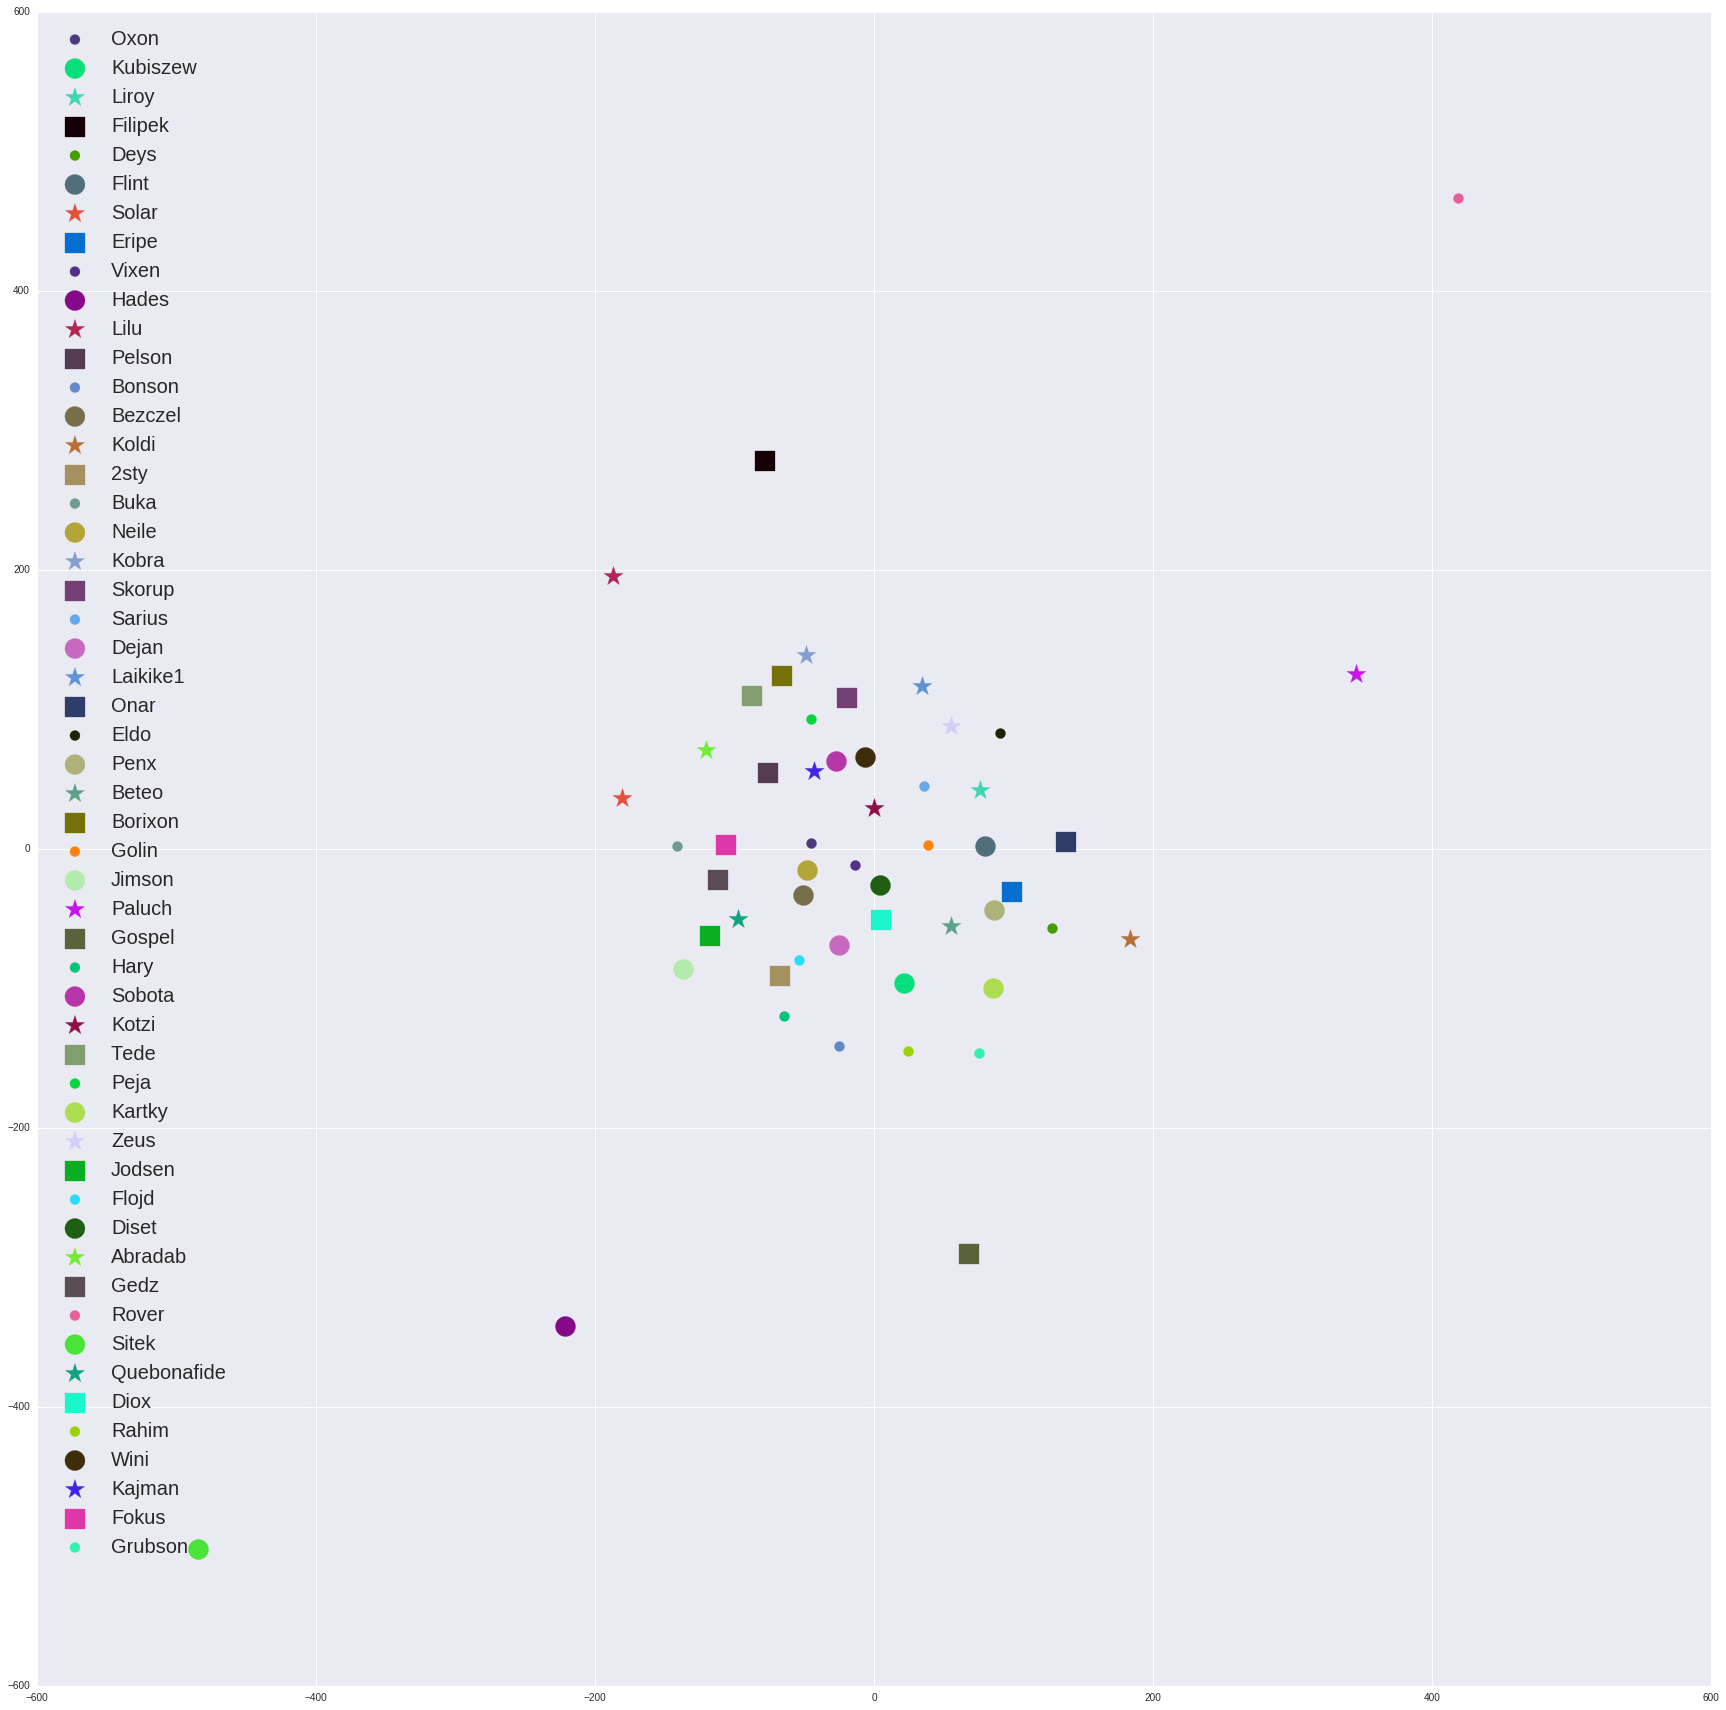

In [102]:
import numpy as np

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(1,1,1)
marker = itertools.cycle((',', '.', 'o', '*'))
print(marker, next(marker))
for r in range(RAPPER_NUM):
    ax.scatter(new_rappers_tsne[r][0], 
               new_rappers_tsne[r][1], 
               color=np.random.rand(3,1), 
               marker=next(marker), 
               label=rappers_mapping[r], 
               s=400)
ax.legend(loc=2, prop={'size':20})
plt.show()

Unfortunately, it is quite difficult to get labels and points together in matplotlib, so better try it in R's ggplot2

In [121]:
df = pd.DataFrame([{"name": rappers_mapping[e], "x": elem[0], "y": elem[1]} for e, elem in enumerate(new_rappers_pca)])

There is some temporary problem with rpy2 library, so it has to be done in separate notebook

In [123]:
# import readline
# import rpy2.robjects

In [ ]:
# %load_ext rpy2.ipython

In [124]:
# %%R -i df
# library(ggplot2)

# ggplot(data=df, aes(x, y, label=name)) + 
#     geom_point() + 
#     geom_text(data = df, vjust=0)

In [125]:
df.to_csv(MAIN_PATH + "rappers_coordinates.csv", sep=";")